# Soft Actor Critic

In [32]:
import jax.numpy as jnp
import jax.random as jrandom
import jax

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from matplotlib import cm

# import local libraries
from src.systems.linear import StochasticDoubleIntegrator
from src.RL.PolicyGradient.SoftActorCritic_v2.main import SoftActorCritic
from src.RL.PolicyGradient.SoftActorCritic_v2.PolicyFunction import SoftPolicyFunction
from src.RL.PolicyGradient.SoftActorCritic_v2.QFunction import SoftQFunction
from src.RL.PolicyGradient.SoftActorCritic_v2.ValueFunction import SoftValueFunction

from src.utilities.ReplayBuffer import ReplayBuffer
from src.utilities.Tracker import Tracker

## Value Iteration

In [4]:
def cost_to_normalized_reward(x):
    x = x/4.1
    return 1 - min(x, 1)*2

def generate_data(system, N, key):
    it = 0
    buffer = np.zeros((N**3, 6))
    x_space = jnp.linspace(-5, 5, N)
    v_space = jnp.linspace(-5, 5, N)
    u_space = jnp.linspace(-2, 2, N)
    for x in x_space:
        for v in v_space:
            for u in u_space:
                state = jnp.array([x, v])
                cost = system.cost(state, u)
                rew = cost_to_normalized_reward(cost)
                key, _ = jrandom.split(key)
                x1, v1 = system.get_state_update(key, state, u)
                buffer[it] = np.array([x, v, u, rew, x1, v1])
                it += 1
    return buffer

key = jrandom.PRNGKey(0)
x0 = jnp.array([2, 0])
SDI = StochasticDoubleIntegrator(x0)
buffer = generate_data(SDI, 10, key)

### Training (VI)

In [16]:
# Training loop
batch_size = 100
n_iter = 1000
lr_v = 1e-1
lr_q = 1e-1
lr_pi = 1e0
key = jrandom.PRNGKey(0)

size = len(buffer)

memory = {'param':np.zeros((n_iter, 2))}

SVF = SoftValueFunction(2, key, eta=lr_v)
SQF = SoftQFunction(3, key, eta=lr_q)
PI = SoftPolicyFunction(2, key, eta=lr_pi)
for it in range(n_iter):
    key, key1, key2, key3, key4 = jrandom.split(key, 5)
    indexes = jrandom.randint(key1, shape=(batch_size,), minval=0, maxval=size)
    state = buffer[indexes,:2]
    full_state = buffer[indexes,:3]
    reward = buffer[indexes,3:4]
    next_state = buffer[indexes, -2:]
    SVF.update(state, SQF.predict, PI, key4)
    SQF.update(full_state, reward, next_state, PI, key2)
    PI.update(state, SQF.predict, key3)

    # Tracking
    memory['param'][it] = PI.model.mu_layer.weight[0]

### Results

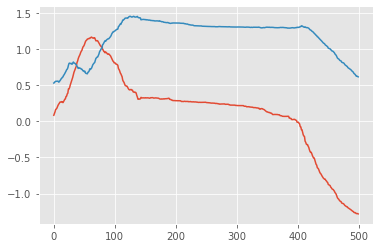

In [14]:
fig, ax = plt.subplots()
ax.plot(memory['param'][:,0])
ax.plot(memory['param'][:,1])
plt.show()

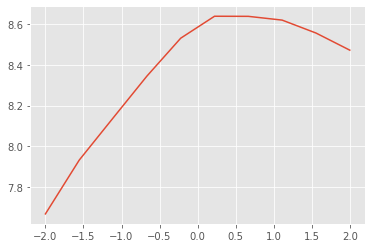

In [5]:

state = -jnp.array([1,1])
u_space = jnp.linspace(-2, 2, 10)
P = np.zeros(10)
for idx, control in enumerate(u_space):
    P[idx] = SQF.predict(state, control)

fig, ax = plt.subplots()
ax.plot(u_space, P)

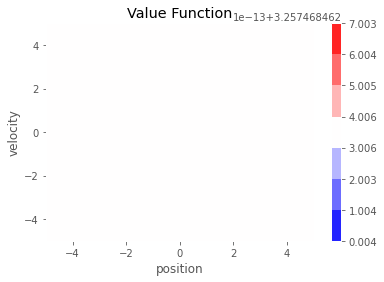

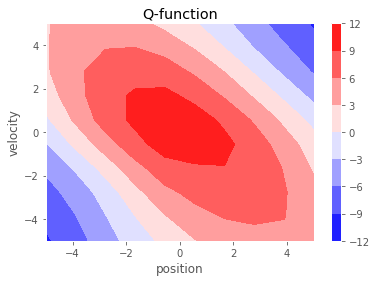

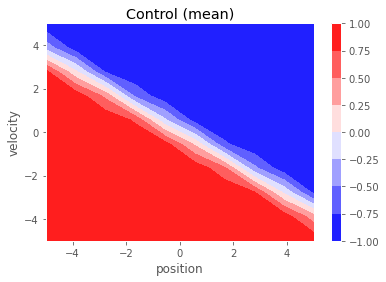

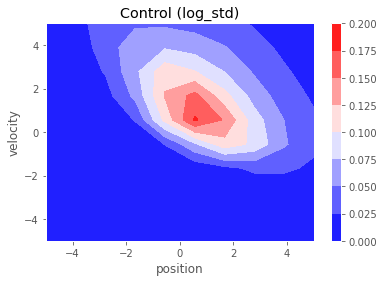

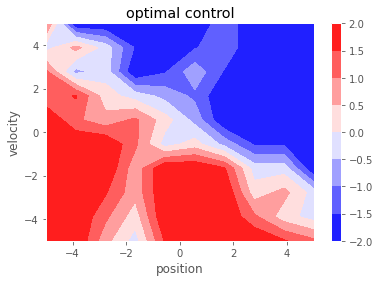

In [17]:
# Plotting
n = 10
x = np.linspace(-5,5,n)
y = np.linspace(-5,5,n)
u_space = np.linspace(-2, 2, n)
xv, yv = np.meshgrid(x,y)
zv = np.zeros((n, n))
zq = np.zeros((n, n))
zu = np.zeros((n, n))
zstd = np.zeros((n, n))
Q = np.zeros((n, n, n))

for i in range(n):
    for j in range(n):
        state = jnp.array([xv[i,j], yv[i,j]])
        for k in range(n):
            u = u_space[k]
            Q[i, j, k] = SQF.predict(state, u)
        v_val = SVF.predict(state)
        q_val = SQF.predict(state, 0)
        u_val, u_log_std = PI.model.predict(state, squash=True)
        zstd[i,j] = u_log_std
        zu[i,j] = u_val
        zv[i,j] = v_val
        zq[i,j] = q_val

plt.contourf(xv, yv, zv, cmap=cm.bwr)
plt.xlabel('position')
plt.ylabel('velocity')
plt.colorbar()
plt.title('Value Function')
plt.show()

plt.contourf(xv, yv, zq, cmap=cm.bwr)
plt.xlabel('position')
plt.ylabel('velocity')
plt.colorbar()
plt.title('Q-function')
plt.show()

plt.contourf(xv, yv, zu, cmap=cm.bwr)
plt.xlabel('position')
plt.ylabel('velocity')
plt.colorbar()
plt.title('Control (mean)')
plt.show()

plt.contourf(xv, yv, zstd, cmap=cm.bwr)
plt.xlabel('position')
plt.ylabel('velocity')
plt.colorbar()
plt.title('Control (log_std)')
plt.show()

Q_idx = np.argmax(Q, axis=2)
Qu = np.zeros_like(Q_idx, dtype=np.float32)
for i, row in enumerate(Q_idx):
    for j, item in enumerate(row):
        Qu[i,j] = u_space[item]

plt.contourf(xv, yv, Qu, cmap=cm.bwr)
plt.xlabel('position')
plt.ylabel('velocity')
plt.colorbar()
plt.title('optimal control')
plt.show()

### Run trial

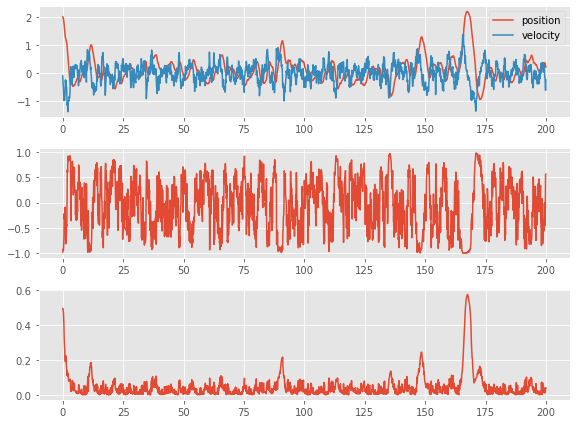

In [191]:
seed = 0
T = 200
n_obs = 2

# Initialize system
x0 = np.array([2, 0])
SDI = StochasticDoubleIntegrator(x0, boundary=10)

key = jrandom.PRNGKey(seed)
key0, key1, key = jrandom.split(key, 3)

time_horizon = jnp.arange(0, T, SDI.dt)
n_iter = len(time_horizon)

X = np.zeros((n_iter, n_obs))
U = np.zeros(n_iter)
C = np.zeros(n_iter)

for it, t in enumerate(time_horizon):
    s0_estimate = SDI.observe(key0)
    control, _ = PI.get_control(s0_estimate, key1)
    state, cost, done = SDI.update(key1, control, info=True)

    # save state
    X[it] = state
    U[it] = control
    C[it] = cost

    # step
    key0, key1, key = jrandom.split(key, 3)
    
    if done:
        X = X[:it]
        U = U[:it]
        C = C[:it]
        time_horizon = time_horizon[:it]
        break

fig, ax = plt.subplots(3, figsize=(8,6))
ax[0].plot(time_horizon, X[:, 0], label='position')
ax[0].plot(time_horizon, X[:, -1], label='velocity')
ax[0].legend()
ax[1].plot(time_horizon, U)
ax[2].plot(time_horizon, C)
plt.tight_layout()

## On-Policy Learning

Not yet working

In [48]:
class SoftActorCritic:
    def __init__(self, observation_size, control_size, key,
                    lr_v=1e-1, lr_q=1e-1, lr_pi=1e-1,
                    batch_size=100, n_epochs=1):
        self.n_obs = observation_size
        self.n_ctrl = control_size

        keys = jrandom.split(key, 5)
        #self.SVF = SoftValueFunction(self.n_obs, keys[0], eta=lr_v)
        self.SQF_1 = SoftQFunction(self.n_obs + self.n_ctrl, keys[1], eta=lr_q)
        self.SQF_2 = SoftQFunction(self.n_obs + self.n_ctrl, keys[2], eta=lr_q)
        self.PI = SoftPolicyFunction(self.n_obs, keys[3], eta=lr_pi)

        # Build replay buffer
        self.ReplayBuffer = ReplayBuffer(buffer_size, observation_size, control_size, keys[4])
        self.batch_size = batch_size
        self.n_epochs = n_epochs

        # Build tracker
        self.tracker = Tracker(['state0', 'state1', 'control', 'reward'])

        # Normalization
        self.max_cost = 4.1
    
    def cost_to_normalized_reward(self, x):
        """
        Cost to reward transformation incl. normalization
        :param x: cost [float]
        :return: normalized reward between (-1,1)
        """
        x = x/self.max_cost
        return 1 - min(x, 1)*2
    
    def q_func(self, state, control):
        """
        Calculate minimal q_value (accelerates learning)
        :param state: state
        :param control: control
        :param output_value: indicate if output should be [float] (True) or [DeviceArray] (False)
        :return: minimal Q-value
        """
        q1 = self.SQF_1.predict(state, control)
        q2 = self.SQF_2.predict(state, control)
        Q = jax.lax.min(q1, q2)
        return Q
    
    def get_control(self, state, key):
        return self.PI.get_control(state, key)

    def train_step(self, key, batch_size):
        keys = jrandom.split(key, 4)

        # sample from buffer
        D = self.ReplayBuffer.sample_batch(batch_size)

        # update SAC components
        state = D[:, :self.n_obs]
        full_state = D[:, :self.n_obs+self.n_ctrl]
        reward = D[:, self.n_obs+self.n_ctrl:-self.n_obs]
        next_state = D[:, -self.n_obs:]

        # Update
        loss_v = None #self.SVF.update(state, self.q_func, PI, keys[0])
        loss_q1 = self.SQF_1.update(full_state, reward, next_state, PI, keys[1])
        loss_q2 = self.SQF_2.update(full_state, reward, next_state, PI, keys[2])
        loss_pi = self.PI.update(state, SQF.predict, keys[3])

        return loss_v, loss_q1, loss_q2, loss_pi
    
    def train(self, key, batch_size=100, n_epochs=5, show=False):
        for epoch in range(n_epochs):
            key, _ = jrandom.split(key)
            loss_v, loss_q1, loss_q2, loss_pi = self.train_step(key, batch_size=batch_size)
            if show:
                print(f'epoch={epoch} \t loss v={loss_v:.3f} \t loss q1={loss_q1:.3f} \t loss q2={loss_q2:.3f} \t loss pi={loss_pi:.3f}')

    def update(self, state_transition, key, tracking=True):
        """
        Update SAC
        :param state_transition: (state, control, reward, new state) [tuple]
        :param key: PRNGKey
        :param tracking: boolean indicates if states are saved [boolean]
        """
        state, control, cost, next_state = state_transition
        reward = self.cost_to_normalized_reward(cost)

        self.ReplayBuffer.store((state, control, reward, next_state))
        self.train(key, batch_size=self.batch_size, n_epochs=self.n_epochs)

        if tracking:
            self.tracker.add([state[0], state[1], control, reward])


In [45]:
seed = 0
T = 10
batch_size = 100

key = jrandom.PRNGKey(seed)
buffer_size = 1000
n_obs, n_ctrl = 2, 1

# Init environment
x0 = jnp.array([2, 0])
SDI = StochasticDoubleIntegrator(x0, boundary=5)
SAC = SoftActorCritic(2, 1, key)

time_horizon = jnp.arange(0, T, SDI.dt)
keys = jrandom.split(key, 6)
s0_estimate = SDI.observe(key)
for t in time_horizon:
    control, _ = SAC.get_control(s0_estimate, keys[0])
    _, cost, done = SDI.update(keys[1], control, info=True)
    s1_estimate = SDI.observe(keys[2])

    state_transition = (s0_estimate, control, cost, s1_estimate)
    SAC.update(state_transition, keys[3])

    # step
    s0_estimate = s1_estimate
    keys = jrandom.split(keys[0], 7)

    if done:
        x0 = jrandom.normal(key, (2,))*2
        SDI.reset(x0)


In [ ]:
key = jrandom.PRNGKey(0)
SAC.train(key, batch_size=100, n_epochs=2, show=False)


### Results

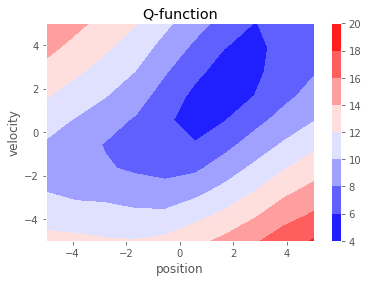

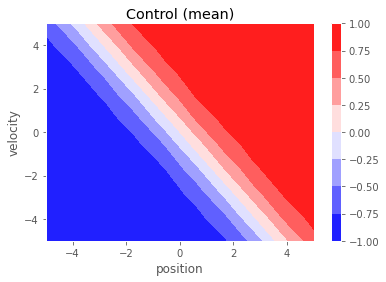

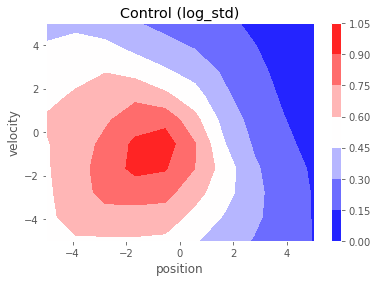

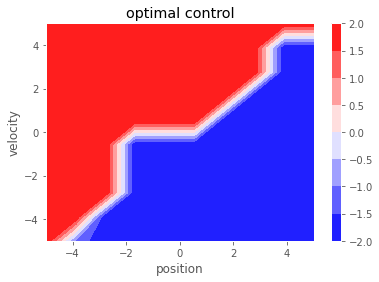

In [47]:
# Plotting
n = 10
x = np.linspace(-5,5,n)
y = np.linspace(-5,5,n)
u_space = np.linspace(-2, 2, n)
xv, yv = np.meshgrid(x,y)
zq1 = np.zeros((n, n))
zq2 = np.zeros((n, n))
zq = np.zeros((n, n))
zu = np.zeros((n, n))
zstd = np.zeros((n, n))
Q = np.zeros((n, n, n))

for i in range(n):
    for j in range(n):
        state = jnp.array([xv[i,j], yv[i,j]])
        for k in range(n):
            u = u_space[k]
            q1_value = SAC.SQF_1.predict(state, u)
            q2_value = SAC.SQF_2.predict(state, u)
            Q[i, j, k] = min(q1_value, q2_value)
        q1_val = SAC.SQF_1.predict(state, 0)
        q2_val = SAC.SQF_2.predict(state, 0)
        u_val, u_log_std = SAC.PI.model.predict(state, squash=True)
        zstd[i,j] = u_log_std
        zu[i,j] = u_val
        zq1[i,j] = q1_val
        zq2[i,j] = q2_val
        zq[i,j] = min(q1_val, q2_val)

plt.contourf(xv, yv, zq, cmap=cm.bwr)
plt.xlabel('position')
plt.ylabel('velocity')
plt.colorbar()
plt.title('Q-function')
plt.show()

plt.contourf(xv, yv, zu, cmap=cm.bwr)
plt.xlabel('position')
plt.ylabel('velocity')
plt.colorbar()
plt.title('Control (mean)')
plt.show()

plt.contourf(xv, yv, zstd, cmap=cm.bwr)
plt.xlabel('position')
plt.ylabel('velocity')
plt.colorbar()
plt.title('Control (log_std)')
plt.show()

Q_idx = np.argmax(Q, axis=2)
Qu = np.zeros_like(Q_idx, dtype=np.float32)
for i, row in enumerate(Q_idx):
    for j, item in enumerate(row):
        Qu[i,j] = u_space[item]

plt.contourf(xv, yv, Qu, cmap=cm.bwr)
plt.xlabel('position')
plt.ylabel('velocity')
plt.colorbar()
plt.title('optimal control')
plt.show()

## Bin

### Neural Networks

In [7]:
class QNetwork(eqx.Module):
    layer: jnp.ndarray
    
    def __init__(self, in_size, key):
        self.layer = eqx.nn.MLP(in_size=in_size, out_size=1, width_size=32, depth=1, key=key)
    
    def __call__(self, x):
        return self.layer(x)


In [8]:
class PolicyNetwork(eqx.Module):
    """
    Network based on Equinox
    """
    mu_layer: jnp.ndarray
    log_std_layer: jnp.ndarray
    control_lim: jnp.float32
    alpha: jnp.float32

    def __init__(self, in_size, key, control_limit=1):
        """
        Initialize network
        :param dim: network dimensions (n_input, ..., n_output)
        :param key: PRNGKey
        """
        key0, key1, key2, key3 = jrandom.split(key, 4)
        self.control_lim = control_limit
        self.alpha = 0

        self.mu_layer = eqx.nn.Linear(in_size, 1, use_bias=False, key=key0)
        self.log_std_layer = eqx.nn.MLP(in_size=in_size, out_size=1, width_size=32, depth=1, key=key1)

    def __call__(self, x, key, deterministic=False):
        """
        Forward propagation
        :param x: input
        :return: network output
        """
        mu, std = self.predict(x)

        if deterministic:
            control = mu
        else:
            control = mu + std * jrandom.normal(key, (1,))
        
        log_prob = -.5 * ((control - mu) / std)**2 - jnp.log(std) + jnp.log(2*jnp.pi)/2
        
        control = self.control_lim * jnp.tanh(control)
        return control, self.alpha*log_prob
    
    def predict(self, x, squash=False):
        """
        Forward propagation
        :param x: input
        :return: network output
        """
        mu = self.mu_layer(x)
        log_std = self.log_std_layer(x)
        std = jnp.exp(log_std)
        if squash:
            return jnp.tanh(mu), std
        else:
            return mu, std


### Policy Function

In [ ]:
class PolicyFunction:
    def __init__(self, in_size, key, eta=1e-2):
        self.model = PolicyNetwork(in_size, key)
        self.optimizer = optax.sgd(eta)
        self.opt_state = self.optimizer.init(self.model)
    
    def loss_fn(self, model, D, q_func, keys):
        control, log_prob = jax.vmap(model)(D, keys)
        q_value = jax.vmap(q_func)(D, control)
        return jnp.mean(log_prob - q_value)

    def update(self, D, q_func, key):
        keys = jrandom.split(key, len(D))
        loss, grads = eqx.filter_value_and_grad(self.loss_fn)(self.model, D, q_func, keys)
        updates, self.opt_state = self.optimizer.update(grads, self.opt_state)
        self.model = eqx.apply_updates(self.model, updates)

    def get_control(self, state, key):
        control, log_prob = self.model(state, key)
        return control, log_prob


### Q-Function

In [ ]:
class SoftQFunction:
    def __init__(self, in_size, key, eta=1e-2):
        self.model = SimpleNetwork((in_size, 32, 1), key)
        #self.model = QNetwork(in_size, key)
        self.optimizer = optax.sgd(eta)
        self.opt_state = self.optimizer.init(self.model)
        self.gamma = .9
    
    def update(self, full_state, reward, next_state, policy, key):
        keys = jrandom.split(key, len(full_state))
        control, log_pi = jax.vmap(policy.get_control)(next_state, keys)
        full_state1 = jnp.hstack([next_state, control])
        q1_hat = jax.vmap(self.model)(full_state1)
        q_target = reward + self.gamma * q1_hat

        loss, grads = eqx.filter_value_and_grad(self.loss_fn)(self.model, full_state, q_target)
        updates, self.opt_state = self.optimizer.update(grads, self.opt_state)
        self.model = eqx.apply_updates(self.model, updates)
        return loss
    
    def loss_fn(self, model, full_state, q_target):
        q0_hat = jax.vmap(model)(full_state)
        bellman_residual = jnp.mean((q0_hat - q_target)**2 / 2)
        return bellman_residual
    
    def predict(self, state, control):
        input = jnp.hstack([state, control])
        return self.model(input)
